## **Machine Learning Final Project DUE: Friday May 7th 11:59pm**

**Note: Please read all the instructions carefully before starting the project.**

For your final project you will build an ML model to analyze a dataset of your choice. You are welcome to keep working on the data in your EDA project if your data is large enough (at least 1000 rows for simple models and at least 10,000 for more complex models) or you can choose from the datasets/project suggestions below.

In this project make sure that you:
- Have a large enough dataset
- Split your data in training and testing
- Explore your data to inform which type of model to choose (no need if you are using your EDA dataset)
- Try different models on your training dataset - then select the most promising model
- Use cross validation to fine tune the model’s parameters such as alpha in lasso
- Simplify your model using regularization, prunnning, drop-out, etc. to avoid overfitting
- Communicate your model’s performance and make sure you compare it to a benchmark when appropriate
- Plot interesting graphs and results
- Write and publish your article to medium
- Commit your code to your GitHub

Please ensure you handle all the preprocessing before the modeling.

Suggestions for project:
You can take a look at the resources given below for choosing a dataset for your project. 

- Traffic sign detection - https://benchmark.ini.rub.de/gtsdb_dataset.html
- Cat and dog classifier - https://www.kaggle.com/c/dogs-vs-cats/data
- Other datasets from Kaggle - https://www.kaggle.com/data/41592

## **Grading Criteria**

- Show clear exploration of the data to justify model choice
- Train mutliple models and clearly articulate why you chose your final model
- Show your performance on test dataset
- Clear and concise write-up with clear well-documented figures
- Commit your code to GitHub

## **Submission Details**

This is an individual assignment. You may not work in groups. The assignment is due on Friday (05/07/2021)
- To submit your assignment, download your notebook and the dataset, zip the dataset and notebook, and submit the zipped file on blackboard.
- Make sure the notebook is named in the format - Final_LastName_FirstName. If you are submitting a zipped file, please name the file as well in the same format.
- Please include the link to access your blog and your github repo in your notebook.
- Also include the link to your notebook, github repo and the blog in the submission on blackboard. Please ensure the TAs have the required access to your notebooks and the github repo.

**Note - If the dataset is too large to be zipped and submitted on blackboard, only submit your notebook, add your dataset to your google drive and share a link to the file in your notebook.**

Medium.com blogpost: https://seantay96.medium.com/german-traffic-sign-classifier-machine-learning-fd573a7ecf14

Github Repository: https://github.com/MiloSta1n/German-Traffic-Sign-Classifier

In [ ]:
# Start solution here

This project will use Python and TensorFlow to classify traffic signs, based on the [German Traffic Signs Dataset](https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/published-archive.html)

In [ ]:
pip uninstall tensorflow

In [ ]:
pip install tensorflow==1.13.2

In [30]:
# Importing Python libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.contrib.layers import flatten

Download the dataset [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip). This dataset has been pickled, with images resized to 32x32. It has three files: train.p (training set), test.p (testing set), valid.p (validation set).

Here, I unzip the dataset and load the data

In [ ]:
!unzip traffic-signs-data.zip
training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [4]:
# Mapping ClassID to traffic sign names
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

**Exploratory Data Analysis**

Following code provides the breakdown of the number of images in each subset, the image size, and the number of classes.

In [5]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_validation = X_valid.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


Sample images will now be plotted from each subset via matplotlib

In [6]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

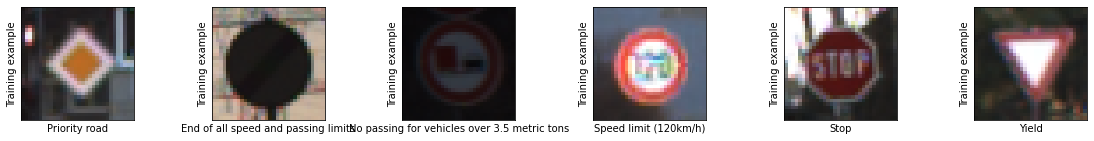

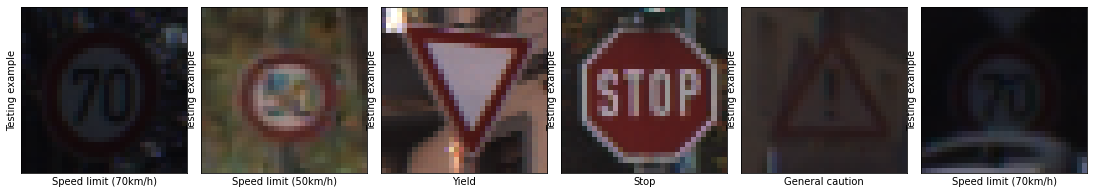

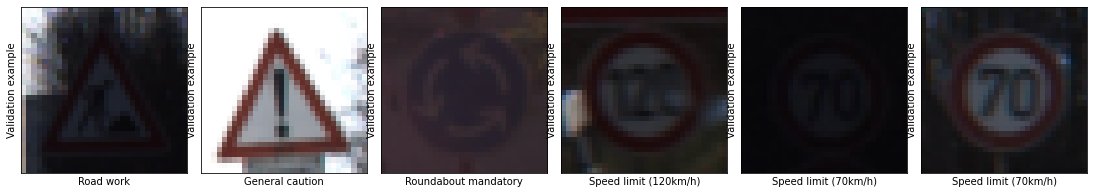

In [7]:
list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")
list_images(X_valid, y_valid, "Validation example")

A histogram of the count of images in each class will be plotted.

In [8]:
def histogram_plot(dataset, label):
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()

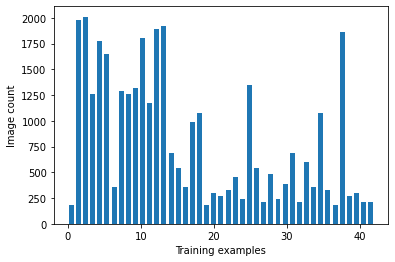

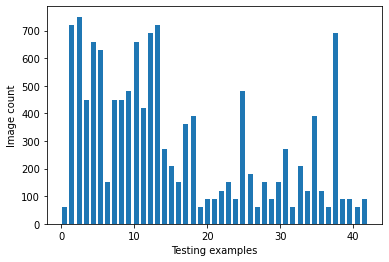

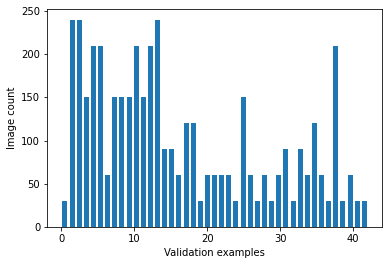

In [9]:
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_valid, "Validation examples")

**Data Preprocessing**

Shuffling - increase randomness and variety in training dataset

In [10]:
X_train, y_train = shuffle(X_train, y_train)

Grayscaling to improve model accuracy

In [11]:
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

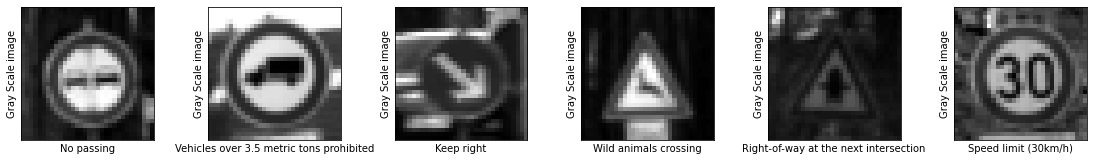

In [12]:
gray_images = list(map(gray_scale, X_train))
list_images(gray_images, y_train, "Gray Scale image", "gray")

Local histogram Equalization - enhances images with low contrast

In [13]:
def local_histo_equalize(image):
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

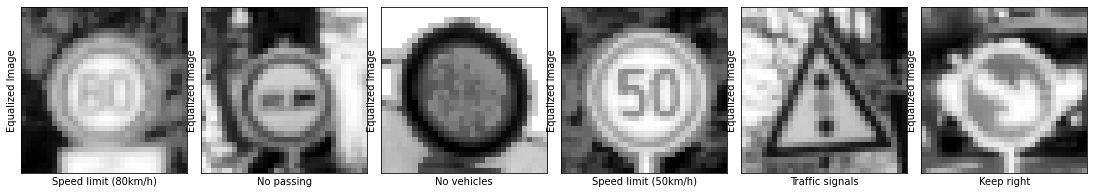

In [14]:
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")

Normalization - normalize data to have mean zero and equal variance



In [15]:
def image_normalize(image):
    image = np.divide(image, 255)
    return image

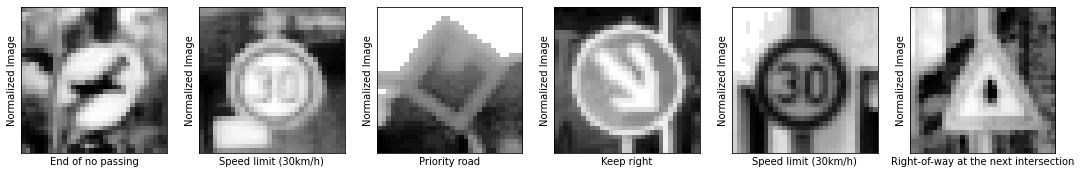

In [16]:
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

Applying the preprocessing steps to the input data

In [17]:
def preprocess(data):
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

Using VGGNet Model Architecture to be implemented with TensorFlow and ReLu Activation.

In [19]:
class VGGnet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        self.conv1 = tf.nn.relu(self.conv1)

        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b

        self.conv2 = tf.nn.relu(self.conv2)

        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv)

        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        self.conv3 = tf.nn.relu(self.conv3)

        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b

        self.conv4 = tf.nn.relu(self.conv4)

        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        self.conv5 = tf.nn.relu(self.conv5)

        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        self.conv6 = tf.nn.relu(self.conv6)

        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        self.fc0   = flatten(self.conv6)

        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
        
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

**Training and Evaluating the Model**

In [20]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

keep_prob and keep_prob_conv controls the dropout rate when training the neural network. This will reduce overfitting of the model.

In [21]:
keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32)  # For convolutional layers

In [22]:
# Preprocess Validation Set
X_valid_preprocessed = preprocess(X_valid)

In [26]:
EPOCHS = 10
BATCH_SIZE = 64
DIR = 'Saved_Models'

In [27]:
VGGNet_Model = VGGnet(n_out = n_classes)
model_name = "VGGNet"

X_valid_preprocessed = preprocess(X_valid)
one_hot_y_valid = tf.one_hot(y_valid, 43)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(VGGNet_Model.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    VGGNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

Training...

EPOCH 1 : Validation Accuracy = 28.367%
EPOCH 2 : Validation Accuracy = 58.254%
EPOCH 3 : Validation Accuracy = 81.859%
EPOCH 4 : Validation Accuracy = 88.549%
EPOCH 5 : Validation Accuracy = 93.628%
EPOCH 6 : Validation Accuracy = 95.510%
EPOCH 7 : Validation Accuracy = 96.553%
EPOCH 8 : Validation Accuracy = 98.345%
EPOCH 9 : Validation Accuracy = 96.712%
EPOCH 10 : Validation Accuracy = 97.846%
Model saved


A Validation Accuracy of 97.85% has been achieved on the 10th Epoch.

**Model Testing using the Test Set**

In [28]:
# Preprocess Test Set
X_test_preprocessed = preprocess(X_test)

In [29]:
with tf.Session() as sess:
    VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
    y_pred = VGGNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Saved_Models/VGGNet
Test Accuracy = 96.3%


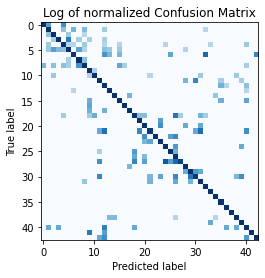

In [31]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Conclusion**

Using VGGNet, we've been able to reach a test accuracy of 96.3%.
Some clusters are observed in the confusion matrix. This is due to various speed limits being sometimes misclassified among themselves. Similarly, traffic signs with triangular shapes are misclassified among themselves.